In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:

sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [6]:

qkv = qkv_layer(x)

In [7]:

qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

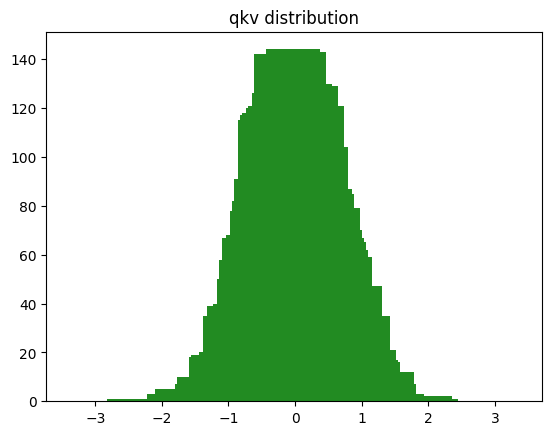

In [8]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [9]:

num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
     

In [10]:

qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:

qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [14]:
import math

In [15]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [16]:

k.T.shape

/var/folders/4j/n0rl6b3s0657t_7z21qxxz6w0000gn/T/ipykernel_99342/514567080.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [ ]:
#Example of transpose
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-1.4862, -1.6871],
        [-1.1417,  0.1465],
        [-0.2672, -0.5831]])

In [18]:
torch.transpose(y, 1, 0)

tensor([[-1.4862, -1.6871],
        [-1.1417,  0.1465],
        [-0.2672, -0.5831]])

In [19]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [20]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [21]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [22]:

(scaled + mask)[0][0]
     

tensor([[ 0.0062,    -inf,    -inf,    -inf],
        [ 0.4323,  0.4474,    -inf,    -inf],
        [-0.1093, -0.1162, -0.2412,    -inf],
        [-0.1716, -0.0213,  0.1810, -0.0288]], grad_fn=<SelectBackward0>)

In [23]:

scaled += mask

In [24]:

attention = F.softmax(scaled, dim=-1)

In [25]:
attention.shape

torch.Size([1, 8, 4, 4])

In [26]:

attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4962, 0.5038, 0.0000, 0.0000],
        [0.3485, 0.3461, 0.3054, 0.0000],
        [0.2110, 0.2453, 0.3003, 0.2434]], grad_fn=<SelectBackward0>)

In [27]:

values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [45]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [46]:

values, attention = scaled_dot_product(q, k, v, mask=mask)

In [47]:

attention.shape

torch.Size([1, 8, 4, 4])

In [48]:

#with mask
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4962, 0.5038, 0.0000, 0.0000],
        [0.3485, 0.3461, 0.3054, 0.0000],
        [0.2110, 0.2453, 0.3003, 0.2434]], grad_fn=<SelectBackward0>)

In [ ]:

# #without mask
# attention[0][0]

tensor([[0.2131, 0.2188, 0.2234, 0.3447],
        [0.2489, 0.2527, 0.2791, 0.2193],
        [0.1921, 0.1907, 0.1683, 0.4489],
        [0.2110, 0.2453, 0.3003, 0.2434]], grad_fn=<SelectBackward0>)

In [49]:

values.size()

torch.Size([1, 8, 4, 64])

In [50]:

values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [51]:
linear_layer = nn.Linear(d_model, d_model)

In [52]:
out = linear_layer(values)

In [53]:

out.shape

torch.Size([1, 4, 512])

In [54]:

out

tensor([[[-0.0567, -0.4768,  0.0399,  ...,  0.2451, -0.2057, -0.1844],
         [-0.1952, -0.0077, -0.1401,  ..., -0.0729, -0.0688, -0.4136],
         [ 0.2346, -0.3781, -0.3045,  ...,  0.0949, -0.2235, -0.0096],
         [-0.3603, -0.1355,  0.0797,  ..., -0.2360,  0.0556,  0.1410]]],
       grad_fn=<ViewBackward0>)

Class

In [55]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [56]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


30 batch size 5 words and 1024 embedding of each <br>
qkv.size(): torch.Size([30, 5, 8, 192]) -- 8 attention head